In [3]:

import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Crée le dossier de sortie des plots
os.makedirs("cells_wsi", exist_ok=True)

# diagnostics
diagnostic_by_image = {
    "11C01217": "C31",
    "11C03865": "C33",
    "11C05932": "C31",
    "11C06723": "C31",
    "11C07872": "C31",
    "11C10663": "C32",
    "11C11784": "C32",
    "11C13378": "C33",
    "12C11017": "C31",
    "13C00067": "C32",
    "13C01530": "C31",
    "13C03386": "C31",
    "13C04279": "C31",
    "13C04957": "C31",
    "13C05735": "C33",
    "13C07440": "C31",
    "13C07927": "C31",
    "13C08641": "C31",
    "13C09250": "C32",
    "13C09634": "C32",
    "13C09975": "C31",
    "13C10343": "C33",
    "13C10757": "C32",
    "13C10759": "C31",
    "14C02999": "C31",
    "14C06236": "C33",
    "14C09039": "C33",
    "14C09524": "C33",
    "14C09564": "C33",
    "14C09565": "C33",
    "14C09799": "C32",
    "14C10452": "C32",
    "14C10454": "C32",
    "14C10457": "C33",
    "14C10466": "C33",
    "14C10964": "C32",
    "14C11607": "C33",
    "14C12430": "C33",
    "14C12432": "C33",
    "15C01600": "C32",
    "15C09394": "C33",
    "16C01776": "C32",
    "16C02221": "C32",
    "16C05953": "C33",
    "16C08414": "C32",
}




def parse_array(val):
    if isinstance(val, str):
        return np.array(ast.literal_eval(val))
    return np.array(val)


def collect_patch_data(parquet_folder):
    data = []
    image_level_summary = []

    for image_folder in os.listdir(parquet_folder):
        print("Image : ", image_folder)
        image_path = os.path.join(parquet_folder, image_folder)
        if not os.path.isdir(image_path):
            continue

        diagnostic = diagnostic_by_image.get(image_folder)
        if diagnostic is None:
            continue

        predictions = []
        probabilities_by_class = {i: [] for i in range(9)}

        for file_name in os.listdir(image_path):
            if not file_name.endswith(".parquet"):
                continue

            full_path = os.path.join(image_path, file_name)
            df = pd.read_parquet(full_path)

            for _, row in df.iterrows():
                pred = row["prediction"]
                prob = parse_array(row["probabilities"])
                predictions.append(pred)

                data.append({
                    "image_id": image_folder,
                    "prediction": pred,
                    "probabilities": prob,
                    "embedding": parse_array(row["embedding"]),
                    "label": diagnostic
                })

                if pred in probabilities_by_class:
                    probabilities_by_class[pred].append(prob)

        # Bar plot
        class_counts = [predictions.count(i) for i in range(9)]  # 0 à 8
        x_labels = ["1", "2", "3", "41", "42", "51", "52", "54", "57"]

        plt.figure(figsize=(8, 5))
        plt.bar(x_labels, class_counts, color='skyblue')
        plt.xlabel("Classe (custom labels)")
        plt.ylabel("Nombre d'occurrences")
        plt.title(f"Distribution des classes - {image_folder}")
        plt.xticks(x_labels)
        plt.tight_layout()
        plot_path = os.path.join("cells_wsi", f"{image_folder}_barplot.png")
        plt.savefig(plot_path)
        plt.close()

        # Résumé par image et par classe
        for cls in range(9):
            probs = probabilities_by_class[cls]
            if probs:
                entropies = [entropy(p) for p in probs]
                mean_entropy = np.mean(entropies)
            else:
                mean_entropy = 0.0

            image_level_summary.append({
                "image_id": image_folder,
                "class_id": cls,
                "cell_count": len(probs),
                "mean_entropy": mean_entropy,
                "label": diagnostic
            })

    df_cells = pd.DataFrame(data)
    df_image_summary = pd.DataFrame(image_level_summary)

    return df_cells, df_image_summary


# Exécution
high_res_parquet_folder = "../../Cytology-fine-tuning/wsi_results_high_res_cluster"
output_cells_path = "patches_with_labels.parquet"
output_summary_path = "image_summary.parquet"

df_all, df_summary = collect_patch_data(high_res_parquet_folder)

df_all.to_parquet(output_cells_path)
df_summary.to_parquet(output_summary_path)

print(f"✅ Fichier cellules : {output_cells_path}")
print(f"✅ Fichier image summary : {output_summary_path}")


Image :  11C01217
Image :  11C03865
Image :  11C05932
Image :  11C06723
Image :  11C07872
Image :  11C10663
Image :  11C11784
Image :  11C13378
Image :  12C11017
Image :  13C00067
Image :  13C01530
Image :  13C03386
Image :  13C04279
Image :  13C04957
Image :  13C05735
Image :  13C07440
Image :  13C07927
Image :  13C08641
Image :  13C09250
Image :  13C09634
Image :  13C09975
Image :  13C10343
Image :  13C10757
Image :  13C10759
Image :  14C02999
Image :  14C06236
Image :  14C09524
Image :  14C09564
Image :  14C09565
Image :  14C09799
Image :  14C10452
Image :  14C10454
Image :  14C10457
Image :  14C10466
Image :  14C10964
Image :  14C11607
Image :  14C12430
Image :  14C12432
Image :  15C01600
Image :  15C09394
Image :  16C01776
Image :  16C02221
Image :  16C05953
Image :  16C08414
✅ Fichier cellules : patches_with_labels.parquet
✅ Fichier image summary : image_summary.parquet


Epoch 01 - Train Loss: 378.3162 - Val Loss: 356.6784
Epoch 02 - Train Loss: 374.6869 - Val Loss: 353.0715
Epoch 03 - Train Loss: 371.0580 - Val Loss: 349.4651
Epoch 04 - Train Loss: 367.4282 - Val Loss: 345.8592
Epoch 05 - Train Loss: 363.7992 - Val Loss: 342.2542
Epoch 06 - Train Loss: 360.1722 - Val Loss: 338.6499
Epoch 07 - Train Loss: 356.5455 - Val Loss: 335.0474
Epoch 08 - Train Loss: 352.9190 - Val Loss: 331.4563
Epoch 09 - Train Loss: 349.2943 - Val Loss: 327.8654
Epoch 10 - Train Loss: 345.6710 - Val Loss: 324.2746
Epoch 11 - Train Loss: 342.0479 - Val Loss: 320.6840
Epoch 12 - Train Loss: 338.4283 - Val Loss: 317.0925
Epoch 13 - Train Loss: 334.8381 - Val Loss: 313.5022
Epoch 14 - Train Loss: 331.2957 - Val Loss: 309.9159
Epoch 15 - Train Loss: 327.7650 - Val Loss: 306.3330
Epoch 16 - Train Loss: 324.2375 - Val Loss: 302.7528
Epoch 17 - Train Loss: 320.7124 - Val Loss: 299.1723
Epoch 18 - Train Loss: 317.1915 - Val Loss: 295.5938
Epoch 19 - Train Loss: 313.6729 - Val Loss: 29

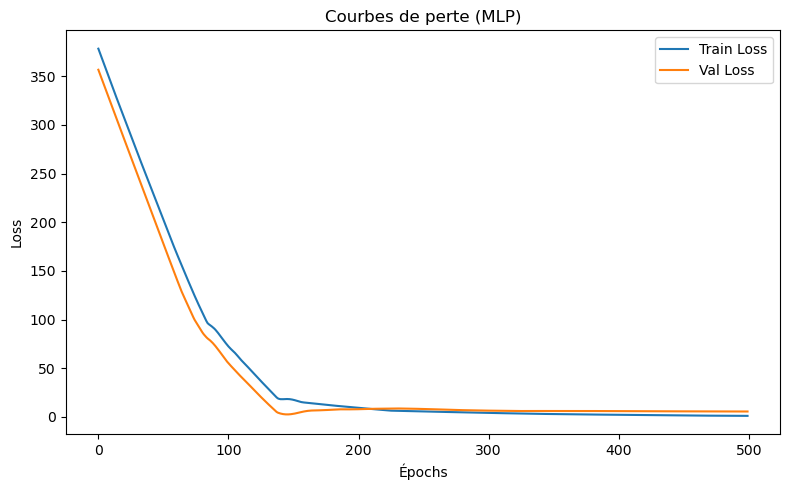

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Charger le fichier
df = pd.read_parquet("image_summary.parquet")

# Encoder le label (C31, C32, C33 -> 0,1,2)
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

# Regrouper les données par image en un vecteur de features
def build_feature_matrix(df_grouped):
    feature_dict = {}
    for _, row in df_grouped.iterrows():
        key = row["image_id"]
        if key not in feature_dict:
            feature_dict[key] = np.zeros((9, 2))  # 9 classes, 2 features: count, entropy
        feature_dict[key][row["class_id"], 0] = row["cell_count"]
        feature_dict[key][row["class_id"], 1] = row["mean_entropy"]
    return feature_dict

features_dict = build_feature_matrix(df)

# Conversion en X, y
X = []
y = []
image_ids = []
for image_id, feat in features_dict.items():
    X.append(feat.flatten())
    label = df[df["image_id"] == image_id]["label_encoded"].iloc[0]
    y.append(label)
    image_ids.append(image_id)

X = np.array(X)
y = np.array(y)

# Split (stratifié pour garder proportions de labels)
X_train, X_temp, y_train, y_temp, id_train, id_temp = train_test_split(
    X, y, image_ids, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42
)

# Convertir en tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Modèle MLP simple
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Entraînement
model = MLP(input_dim=18, hidden_dim=64, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)

train_losses = []
val_losses = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1:02d} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")
accuracy = (model(X_test).argmax(dim=1) == y_test).float().mean().item()
print(f"✅ Test Accuracy: {accuracy:.4f}")

# Plots des pertes
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.title("Courbes de perte (MLP)")
plt.legend()
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 23 candidates, totalling 115 fits
✅ Best parameters found:
{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid'}

📊 Classification Report (Test Set):

              precision    recall  f1-score   support

         C31       0.50      0.40      0.44         5
         C32       0.44      1.00      0.62         4
         C33       0.00      0.00      0.00         5

    accuracy                           0.43        14
   macro avg       0.31      0.47      0.35        14
weighted avg       0.31      0.43      0.33        14



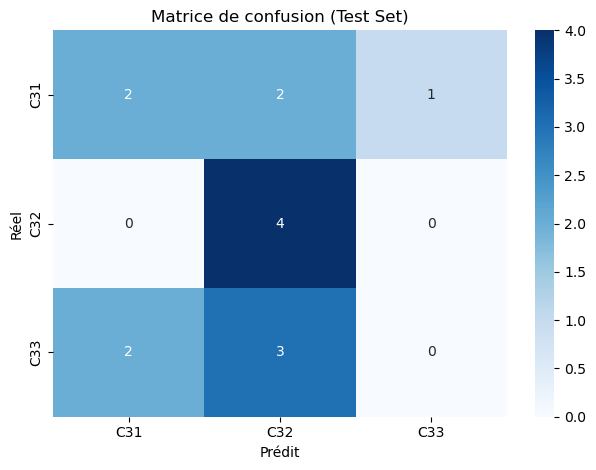

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_parquet("image_summary.parquet")

# Encodage des labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

# Création des features
features_dict = {}
for _, row in df.iterrows():
    img = row["image_id"]
    if img not in features_dict:
        features_dict[img] = np.zeros((9, 2))  # 9 classes
    features_dict[img][row["class_id"], 0] = row["cell_count"]
    features_dict[img][row["class_id"], 1] = row["mean_entropy"]

X = np.array([v.flatten() for v in features_dict.values()])
y = np.array([df[df["image_id"] == k]["label_encoded"].iloc[0] for k in features_dict.keys()])

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
from sklearn.model_selection import StratifiedKFold

# Définir StratifiedKFold pour garantir une bonne distribution des classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Paramètre Grid avec multiples kernels et StratifiedKFold
param_grid = [
    {
        'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100],
        'class_weight': ['balanced']
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.001],
        # 'class_weight': ['balanced']
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10],
        'degree': [2, 3],
        'gamma': ['scale'],
        'class_weight': ['balanced']
    },
    {
        'kernel': ['sigmoid'],
        'C': [0.1, 1, 10],
        'gamma': ['scale'],
        'class_weight': ['balanced']
    }
]

# GridSearchCV avec la validation croisée StratifiedKFold
grid = GridSearchCV(SVC(), param_grid, cv=cv, scoring='f1_weighted', verbose=1)
grid.fit(X_train_scaled, y_train)

# Afficher les meilleurs paramètres trouvés
print("✅ Best parameters found:")
print(grid.best_params_)

# Prédictions avec le meilleur modèle
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Résultats sur le set de test
print("\n📊 Classification Report (Test Set):\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion pour le test set
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (Test Set)")
plt.tight_layout()
plt.show()



===== Fold 1 =====
Epoch 1, Loss = 1.0931, Val Acc = 0.2222
Epoch 2, Loss = 1.0926, Val Acc = 0.2222
Epoch 3, Loss = 1.0920, Val Acc = 0.2222
Epoch 4, Loss = 1.0915, Val Acc = 0.2222
Epoch 5, Loss = 1.0910, Val Acc = 0.2222
Epoch 6, Loss = 1.0905, Val Acc = 0.2222
Epoch 7, Loss = 1.0900, Val Acc = 0.2222
Epoch 8, Loss = 1.0895, Val Acc = 0.2222
Epoch 9, Loss = 1.0890, Val Acc = 0.2222
Epoch 10, Loss = 1.0885, Val Acc = 0.2222
Epoch 11, Loss = 1.0881, Val Acc = 0.2222
Epoch 12, Loss = 1.0877, Val Acc = 0.2222
Epoch 13, Loss = 1.0872, Val Acc = 0.2222
Epoch 14, Loss = 1.0868, Val Acc = 0.2222
Epoch 15, Loss = 1.0864, Val Acc = 0.2222
Epoch 16, Loss = 1.0860, Val Acc = 0.2222
Epoch 17, Loss = 1.0856, Val Acc = 0.2222
Epoch 18, Loss = 1.0852, Val Acc = 0.2222
Epoch 19, Loss = 1.0848, Val Acc = 0.2222
Epoch 20, Loss = 1.0845, Val Acc = 0.2222
Epoch 21, Loss = 1.0841, Val Acc = 0.2222
Epoch 22, Loss = 1.0838, Val Acc = 0.2222
Epoch 23, Loss = 1.0834, Val Acc = 0.2222
Epoch 24, Loss = 1.0831

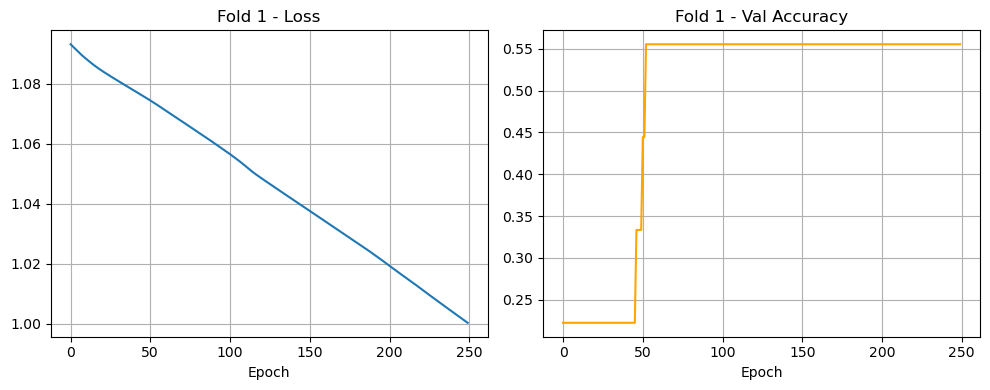


===== Fold 2 =====
Epoch 1, Loss = 1.0974, Val Acc = 0.4444
Epoch 2, Loss = 1.0969, Val Acc = 0.4444
Epoch 3, Loss = 1.0964, Val Acc = 0.4444
Epoch 4, Loss = 1.0959, Val Acc = 0.4444
Epoch 5, Loss = 1.0953, Val Acc = 0.4444
Epoch 6, Loss = 1.0948, Val Acc = 0.4444
Epoch 7, Loss = 1.0943, Val Acc = 0.6667
Epoch 8, Loss = 1.0937, Val Acc = 0.6667
Epoch 9, Loss = 1.0932, Val Acc = 0.4444
Epoch 10, Loss = 1.0927, Val Acc = 0.4444
Epoch 11, Loss = 1.0922, Val Acc = 0.3333
Epoch 12, Loss = 1.0917, Val Acc = 0.3333
Epoch 13, Loss = 1.0912, Val Acc = 0.3333
Epoch 14, Loss = 1.0907, Val Acc = 0.3333
Epoch 15, Loss = 1.0903, Val Acc = 0.3333
Epoch 16, Loss = 1.0898, Val Acc = 0.2222
Epoch 17, Loss = 1.0893, Val Acc = 0.2222
Epoch 18, Loss = 1.0889, Val Acc = 0.2222
Epoch 19, Loss = 1.0885, Val Acc = 0.2222
Epoch 20, Loss = 1.0880, Val Acc = 0.2222
Epoch 21, Loss = 1.0876, Val Acc = 0.2222
Epoch 22, Loss = 1.0872, Val Acc = 0.2222
Epoch 23, Loss = 1.0868, Val Acc = 0.2222
Epoch 24, Loss = 1.0864

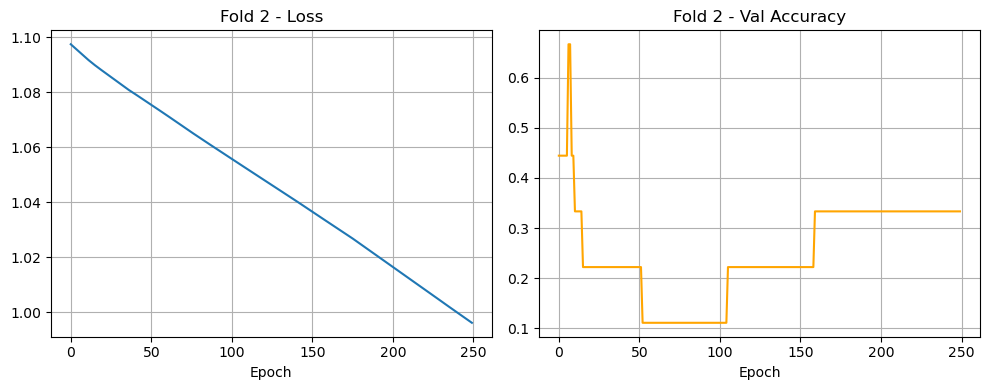


===== Fold 3 =====
Epoch 1, Loss = 1.0939, Val Acc = 0.1111
Epoch 2, Loss = 1.0935, Val Acc = 0.1111
Epoch 3, Loss = 1.0930, Val Acc = 0.1111
Epoch 4, Loss = 1.0925, Val Acc = 0.1111
Epoch 5, Loss = 1.0921, Val Acc = 0.1111
Epoch 6, Loss = 1.0916, Val Acc = 0.1111
Epoch 7, Loss = 1.0911, Val Acc = 0.1111
Epoch 8, Loss = 1.0907, Val Acc = 0.1111
Epoch 9, Loss = 1.0903, Val Acc = 0.1111
Epoch 10, Loss = 1.0899, Val Acc = 0.1111
Epoch 11, Loss = 1.0894, Val Acc = 0.1111
Epoch 12, Loss = 1.0890, Val Acc = 0.1111
Epoch 13, Loss = 1.0886, Val Acc = 0.1111
Epoch 14, Loss = 1.0882, Val Acc = 0.1111
Epoch 15, Loss = 1.0878, Val Acc = 0.1111
Epoch 16, Loss = 1.0873, Val Acc = 0.1111
Epoch 17, Loss = 1.0869, Val Acc = 0.1111
Epoch 18, Loss = 1.0865, Val Acc = 0.1111
Epoch 19, Loss = 1.0861, Val Acc = 0.1111
Epoch 20, Loss = 1.0857, Val Acc = 0.1111
Epoch 21, Loss = 1.0853, Val Acc = 0.2222
Epoch 22, Loss = 1.0849, Val Acc = 0.2222
Epoch 23, Loss = 1.0845, Val Acc = 0.2222
Epoch 24, Loss = 1.0841

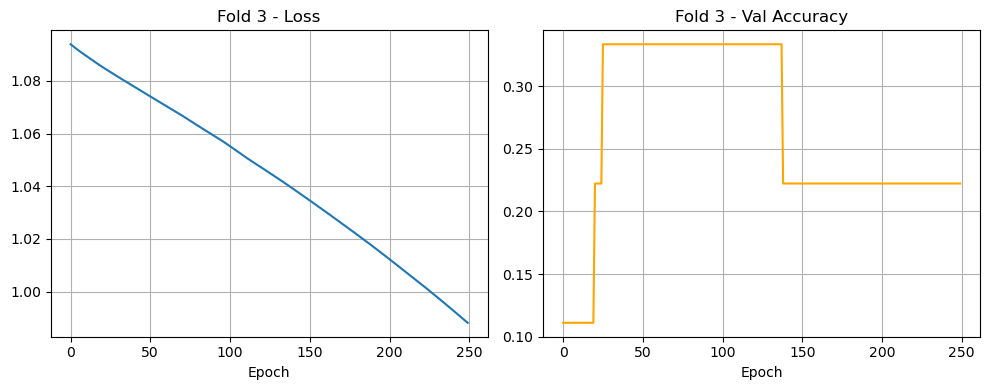


===== Fold 4 =====
Epoch 1, Loss = 1.1125, Val Acc = 0.6667
Epoch 2, Loss = 1.1116, Val Acc = 0.6667
Epoch 3, Loss = 1.1106, Val Acc = 0.6667
Epoch 4, Loss = 1.1097, Val Acc = 0.6667
Epoch 5, Loss = 1.1088, Val Acc = 0.6667
Epoch 6, Loss = 1.1078, Val Acc = 0.6667
Epoch 7, Loss = 1.1069, Val Acc = 0.6667
Epoch 8, Loss = 1.1060, Val Acc = 0.6667
Epoch 9, Loss = 1.1051, Val Acc = 0.6667
Epoch 10, Loss = 1.1042, Val Acc = 0.5556
Epoch 11, Loss = 1.1033, Val Acc = 0.4444
Epoch 12, Loss = 1.1025, Val Acc = 0.2222
Epoch 13, Loss = 1.1016, Val Acc = 0.2222
Epoch 14, Loss = 1.1007, Val Acc = 0.2222
Epoch 15, Loss = 1.0999, Val Acc = 0.2222
Epoch 16, Loss = 1.0990, Val Acc = 0.0000
Epoch 17, Loss = 1.0982, Val Acc = 0.0000
Epoch 18, Loss = 1.0974, Val Acc = 0.0000
Epoch 19, Loss = 1.0966, Val Acc = 0.0000
Epoch 20, Loss = 1.0957, Val Acc = 0.0000
Epoch 21, Loss = 1.0950, Val Acc = 0.0000
Epoch 22, Loss = 1.0942, Val Acc = 0.0000
Epoch 23, Loss = 1.0934, Val Acc = 0.0000
Epoch 24, Loss = 1.0927

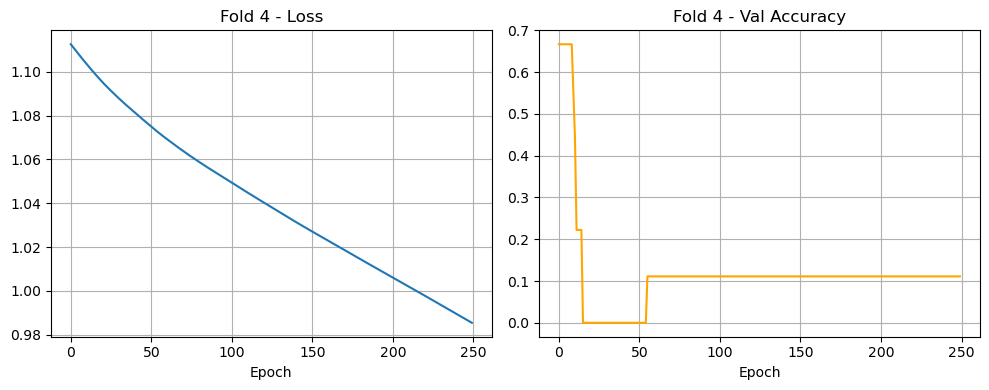


===== Fold 5 =====
Epoch 1, Loss = 1.0913, Val Acc = 0.1250
Epoch 2, Loss = 1.0908, Val Acc = 0.1250
Epoch 3, Loss = 1.0903, Val Acc = 0.1250
Epoch 4, Loss = 1.0898, Val Acc = 0.1250
Epoch 5, Loss = 1.0893, Val Acc = 0.1250
Epoch 6, Loss = 1.0888, Val Acc = 0.1250
Epoch 7, Loss = 1.0883, Val Acc = 0.1250
Epoch 8, Loss = 1.0878, Val Acc = 0.1250
Epoch 9, Loss = 1.0873, Val Acc = 0.1250
Epoch 10, Loss = 1.0868, Val Acc = 0.1250
Epoch 11, Loss = 1.0863, Val Acc = 0.1250
Epoch 12, Loss = 1.0858, Val Acc = 0.1250
Epoch 13, Loss = 1.0853, Val Acc = 0.1250
Epoch 14, Loss = 1.0848, Val Acc = 0.1250
Epoch 15, Loss = 1.0843, Val Acc = 0.1250
Epoch 16, Loss = 1.0838, Val Acc = 0.1250
Epoch 17, Loss = 1.0834, Val Acc = 0.1250
Epoch 18, Loss = 1.0829, Val Acc = 0.1250
Epoch 19, Loss = 1.0824, Val Acc = 0.1250
Epoch 20, Loss = 1.0819, Val Acc = 0.1250
Epoch 21, Loss = 1.0814, Val Acc = 0.1250
Epoch 22, Loss = 1.0809, Val Acc = 0.1250
Epoch 23, Loss = 1.0804, Val Acc = 0.1250
Epoch 24, Loss = 1.0799

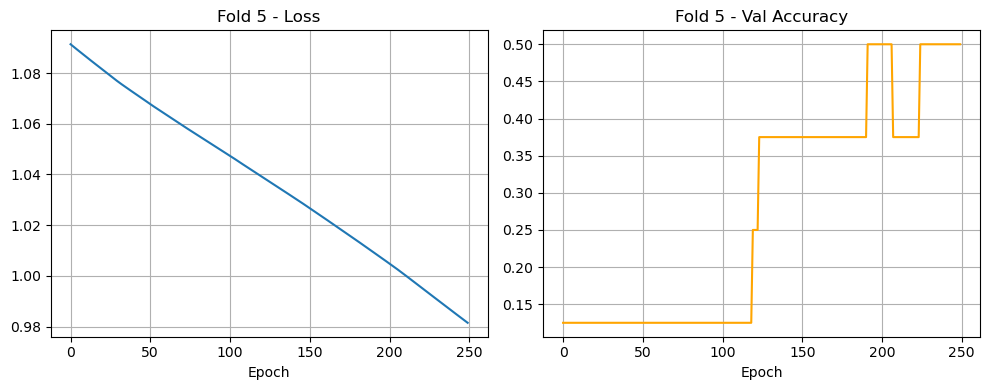


===== Résultat Global (K-Fold) =====
Accuracy moyenne : 0.3444
Accuracy min/max : 0.1111 / 0.5556


In [103]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)

# === Chargement et parsing des données ===
output_path = "patches_with_labels.parquet"
df_all = pd.read_parquet(output_path)

def safe_parse(x):
    if isinstance(x, np.ndarray):
        if x.dtype == object and len(x) > 0:
            return x[0].astype(np.float32)
        else:
            return x.astype(np.float32)
    elif isinstance(x, list):
        return np.array(x, dtype=np.float32)
    else:
        return np.array(x, dtype=np.float32)

df_all["embedding"] = df_all["embedding"].apply(safe_parse)

def safe_parse_probs(x):
    if isinstance(x, np.ndarray):
        return x.astype(np.float32)
    elif isinstance(x, list):
        return np.array(x, dtype=np.float32)
    else:
        return np.array(x, dtype=np.float32)

df_all["probabilities"] = df_all["probabilities"].apply(safe_parse_probs)

df_all = df_all[
    df_all["embedding"].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 1) &
    df_all["probabilities"].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 1)
]

le = LabelEncoder()
df_all["label_id"] = le.fit_transform(df_all["label"])

# === Dataset personnalisé ===
class FeatureDataset(Dataset):
    def __init__(self, df):
        self.data = df.groupby('image_id').agg({
            'embedding': lambda x: np.mean(np.vstack(x), axis=0),
            'probabilities': lambda x: np.mean(np.vstack(x), axis=0),
            'label_id': 'first'
        }).reset_index()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        emb = self.data.iloc[idx]['embedding']
        # pred = self.data.iloc[idx]['prediction']
        prob = self.data.iloc[idx]['probabilities']
        label = self.data.iloc[idx]['label_id']
        features = np.concatenate([emb, prob])
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# === Modèle MLP ===
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

# === Évaluation ===
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.cuda(), yb.cuda()
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

# === K-Fold ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
image_ids = df_all["image_id"].unique()
image_to_label = df_all.groupby("image_id")["label_id"].first()

all_val_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(image_ids)):
    print(f"\n===== Fold {fold+1} =====")

    train_ids = image_ids[train_idx]
    val_ids = image_ids[val_idx]

    df_train = df_all[df_all["image_id"].isin(train_ids)]
    df_val = df_all[df_all["image_id"].isin(val_ids)]

    train_dataset = FeatureDataset(df_train)
    val_dataset = FeatureDataset(df_val)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512)

    input_dim = train_dataset[0][0].shape[0]
    output_dim = len(le.classes_)
    model = MLP(input_dim, output_dim).cuda()
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-1)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []

    for epoch in range(250):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.cuda(), yb.cuda()
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_acc = evaluate(model, val_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Loss = {avg_loss:.4f}, Val Acc = {val_acc:.4f}")

    all_val_scores.append(val_accuracies[-1])

    # Plot pour ce fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.title(f"Fold {fold+1} - Loss")
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Val Acc", color="orange")
    plt.xlabel("Epoch")
    plt.title(f"Fold {fold+1} - Val Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Résultat final sur tous les folds ===
print(f"\n===== Résultat Global (K-Fold) =====")
print(f"Accuracy moyenne : {np.mean(all_val_scores):.4f}")
print(f"Accuracy min/max : {np.min(all_val_scores):.4f} / {np.max(all_val_scores):.4f}")
